In [183]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [184]:
!pip install --quiet pillow matplotlib torchvision


[notice] A new release of pip is available: 24.3.1 -> 26.0
[notice] To update, run: pip install --upgrade pip


In [185]:
import os
import urllib.request
import tarfile

os.makedirs("../Data", exist_ok=True)

dataset_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
annotations_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"

def download_and_extract(url, dest):
    filename = url.split("/")[-1]
    path = os.path.join(dest, filename)
    if not os.path.exists(path.replace(".tar.gz","")):
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, path)
        print(f"Extracting {filename}...")
        with tarfile.open(path) as tar:
            tar.extractall(dest)
download_and_extract(dataset_url, "Data")
download_and_extract(annotations_url, "Data")

In [186]:
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

class OxfordPetsDataset(Dataset):
    def __init__(self, root, image_transform=None, mask_transform=None):
        self.root = root
        self.image_dir = os.path.join(root, 'images')
        self.mask_dir = os.path.join(root, "annotations", "trimaps")

        # Берем только реальные файлы
        images = [f for f in os.listdir(self.image_dir) if f.lower().endswith('.jpg')]
        masks = [f for f in os.listdir(self.mask_dir) if f.lower().endswith('.png')]

        # Сопоставляем по имени без расширения
        mask_names = {os.path.splitext(f)[0]: f for f in masks}
        self.images = []
        self.masks = []

        for img in images:
            name = os.path.splitext(img)[0]
            if name in mask_names:
                self.images.append(img)
                self.masks.append(mask_names[name])

        self.images.sort()
        self.masks.sort()

        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        mask = torch.from_numpy(np.array(mask)).long()
        mask = torch.where(mask > 1, 1, 0)

        return image, mask

In [187]:
image_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])
mask_transform = T.Compose([
    T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST)
])

dataset = OxfordPetsDataset(
    root="Data",
    image_transform=image_transform,
    mask_transform=mask_transform
)
print("Dataset size:", len(dataset))

Dataset size: 7390


In [188]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)

In [189]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.down = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_ch,out_ch))
    def forward(self,x): return self.down(x)

class Up(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.conv = DoubleConv(out_ch + skip_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2, diffY//2, diffY-diffY//2])
        return self.conv(torch.cat([x2, x1], dim=1))

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()
        self.inc = DoubleConv(n_channels,64)
        self.down1 = Down(64,128)
        self.down2 = Down(128,256)
        self.down3 = Down(256,512)
        self.down4 = Down(512,512)
        self.up1 = Up(512,512,256)
        self.up2 = Up(256,256,128)
        self.up3 = Up(128,128,64)
        self.up4 = Up(64,64,64)
        self.outc = nn.Conv2d(64,n_classes,1)
    def forward(self,x):
        x1 = self.inc(x); x2 = self.down1(x1); x3 = self.down2(x2)
        x4 = self.down3(x3); x5 = self.down4(x4)
        x = self.up1(x5,x4); x = self.up2(x,x3)
        x = self.up3(x,x2); x = self.up4(x,x1)
        return self.outc(x)

model = UNet().to(device)

In [190]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0): super().__init__(); self.smooth = smooth
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        targets = targets.float()
        intersection = (probs*targets).sum(dim=(2,3))
        union = probs.sum(dim=(2,3)) + targets.sum(dim=(2,3))
        dice = (2*intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

bce_loss = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()

def segmentation_loss(logits, targets):
    return bce_loss(logits, targets.float()) + dice_loss(logits, targets)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

In [191]:
def dice_score(logits, targets, threshold=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs>threshold).float()
    targets = targets.float()
    intersection = (preds*targets).sum(dim=(2,3))
    union = preds.sum(dim=(2,3)) + targets.sum(dim=(2,3))
    dice = (2*intersection + 1e-7) / (union + 1e-7)
    return dice.mean().item()

def train_one_epoch(model, loader, optimizer):
    model.train(); epoch_loss = 0
    for images, masks in loader:
        images, masks = images.to(device), masks.unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = segmentation_loss(outputs, masks)
        loss.backward(); optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def validate(model, loader):
    model.eval(); val_loss = 0; val_dice = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.unsqueeze(1).to(device)
            outputs = model(images)
            val_loss += segmentation_loss(outputs, masks).item()
            val_dice += dice_score(outputs, masks)
    return val_loss/len(loader), val_dice/len(loader)


In [192]:
best_val_dice = 0.0

num_epochs = 20
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_dice = validate(model, val_loader)

    scheduler.step(val_loss)

    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_dice": best_val_dice,
        }, "best_model.pth")

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Dice: {val_dice:.4f}"
    )

Traceback (most recent call last):
  File "<string>", line 1, in <module>
    from multiprocessing.spawn import spawn_main; spawn_main(tracker_fd=107, pipe_handle=121)
                                                  ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'OxfordPetsDataset' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>


KeyboardInterrupt: 

In [193]:
import matplotlib.pyplot as plt
import torch

def visualize_predictions(model, dataset, device, num_samples=5):
    """
    Визуализирует предсказания модели на нескольких примерах из датасета.

    model     - обученная модель (U-Net)
    dataset   - torch Dataset
    device    - "cpu" или "cuda"
    num_samples - сколько примеров показывать
    """
    model.eval()  # переключаем модель в eval режим

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))

    with torch.no_grad():
        for i in range(num_samples):
            image, mask = dataset[i]

            # добавляем batch размерность
            input_img = image.unsqueeze(0).to(device)
            output = model(input_img)

            # бинаризация предсказания
            pred = torch.sigmoid(output)[0, 0].cpu().numpy()
            pred = (pred > 0.5).astype("uint8")

            img = image.permute(1, 2, 0).cpu().numpy()  # [H, W, C]
            gt_mask = mask.cpu().numpy()

            # подбираем оси
            ax1, ax2, ax3 = axes[i]
            ax1.imshow(img)
            ax1.set_title("Image")
            ax1.axis("off")

            ax2.imshow(gt_mask, cmap="gray")
            ax2.set_title("Ground Truth")
            ax2.axis("off")

            ax3.imshow(pred, cmap="gray")
            ax3.set_title("Prediction")
            ax3.axis("off")

    plt.tight_layout()
    plt.savefig("prediction.png")
    plt.show()

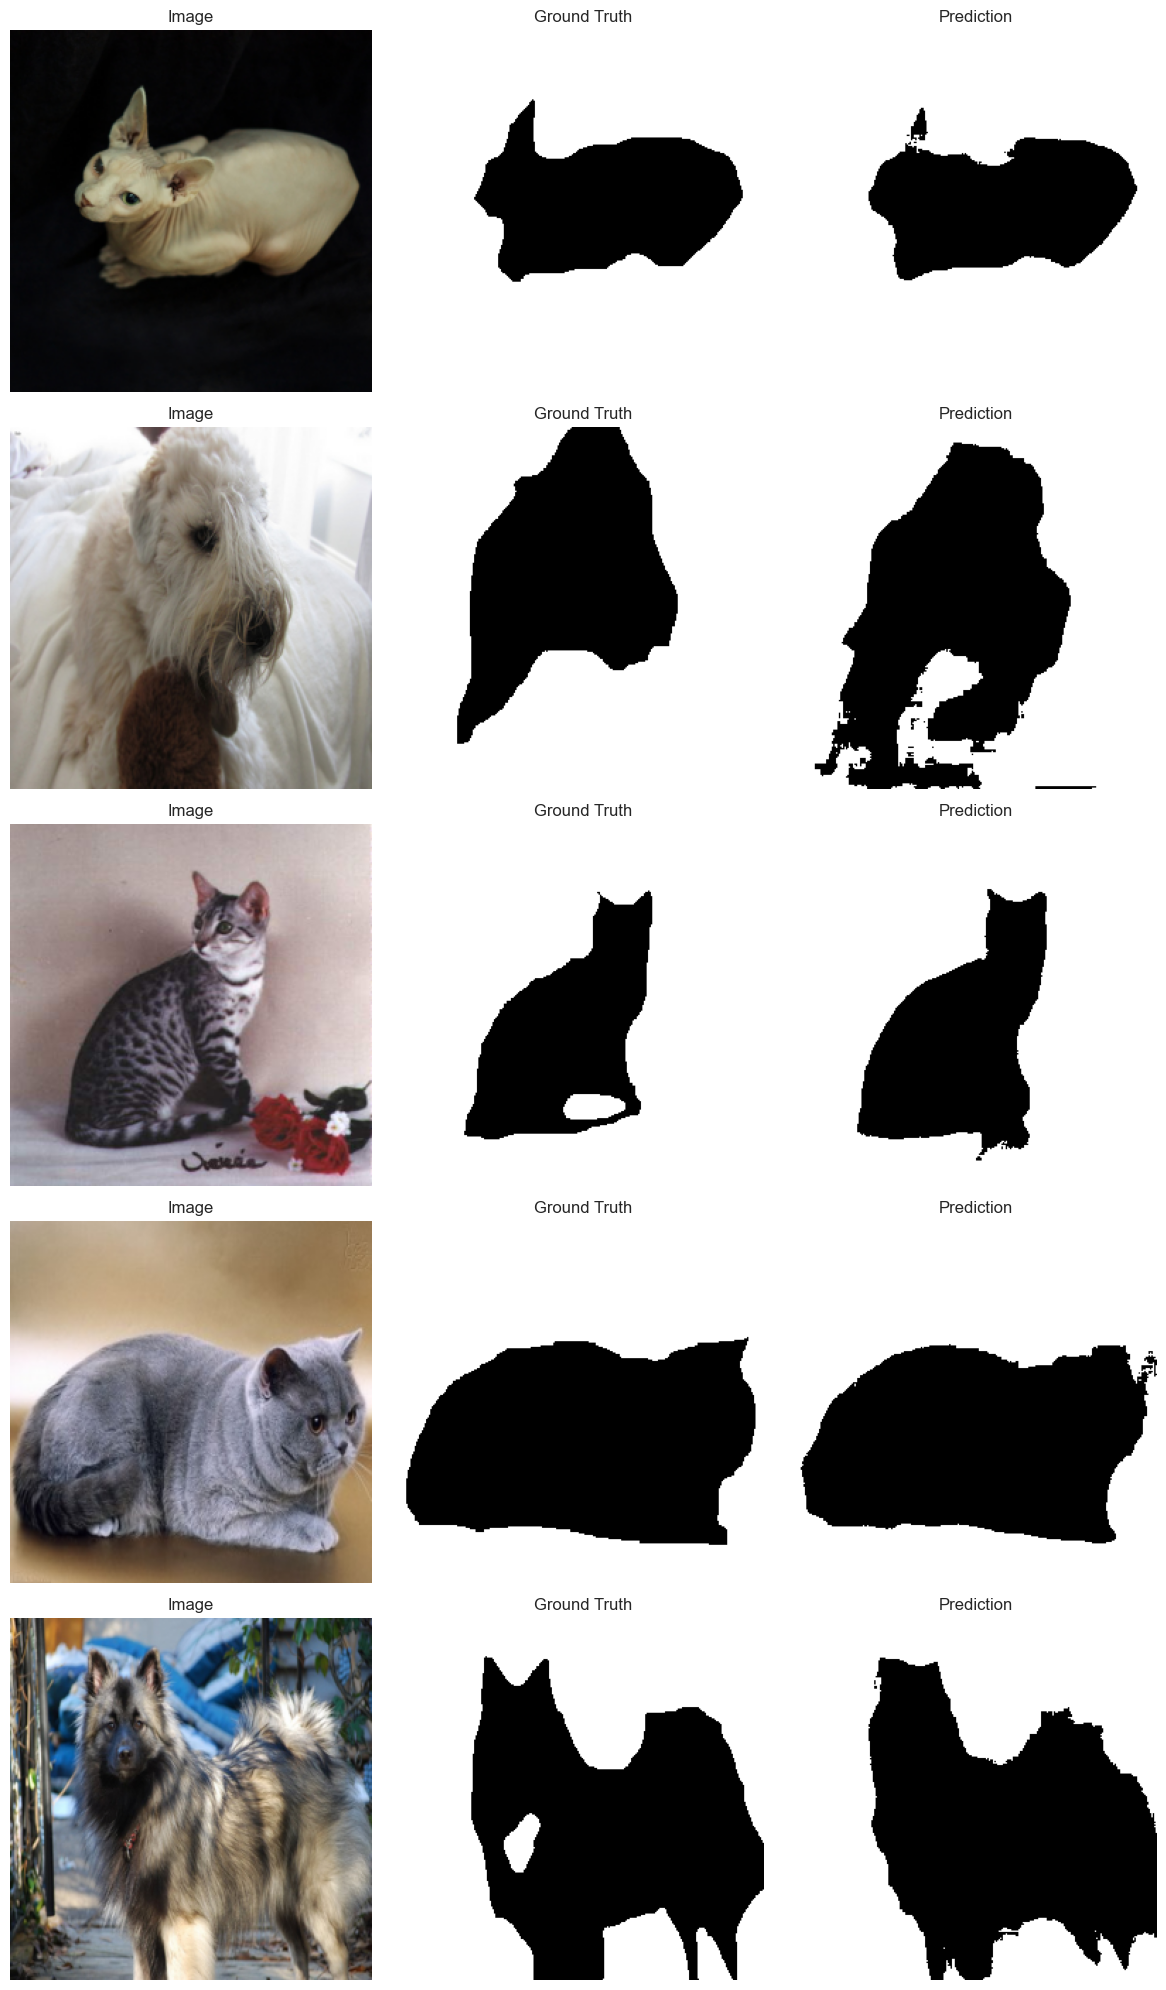

In [194]:
checkpoint = torch.load("best_model.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)

# визуализируем 5 примеров
visualize_predictions(model, val_ds, device, num_samples=5)

In [195]:
import os

output_dir = "../outputs/examples"
os.makedirs(output_dir, exist_ok=True)

In [196]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_and_save_overlay(model, dataset, device, num_samples=5, output_dir="examples"):
    """
    Визуализирует предсказания и сохраняет overlay images.
    """
    model.eval()

    with torch.no_grad():
        for i in range(num_samples):
            image, mask = dataset[i]

            input_img = image.unsqueeze(0).to(device)
            output = model(input_img)

            pred = torch.sigmoid(output)[0, 0].cpu().numpy()
            pred_bin = (pred > 0.5).astype("uint8")

            img = (image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
            gt_mask = mask.cpu().numpy()

            # создаём overlay: красная маска на изображении
            overlay = img.copy()
            overlay[pred_bin == 1] = [255, 0, 0]  # красная маска

            fig, axes = plt.subplots(1, 3, figsize=(12, 4))

            axes[0].imshow(img)
            axes[0].set_title("Image")
            axes[0].axis("off")

            axes[1].imshow(gt_mask, cmap="gray")
            axes[1].set_title("Ground Truth")
            axes[1].axis("off")

            axes[2].imshow(overlay)
            axes[2].set_title("Prediction Overlay")
            axes[2].axis("off")

            plt.tight_layout()
            save_path = os.path.join(output_dir, f"sample_{i+1}.png")
            plt.savefig(save_path)
            plt.close(fig)

In [197]:
# визуализируем и сохраняем 5 примеров
visualize_and_save_overlay(model, val_ds, device, num_samples=5, output_dir=output_dir)